In [1]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models (DDPM) with miniai

## Imports

In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load dataset

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
dt = dls.train
xb, yb = next(iter(dt))

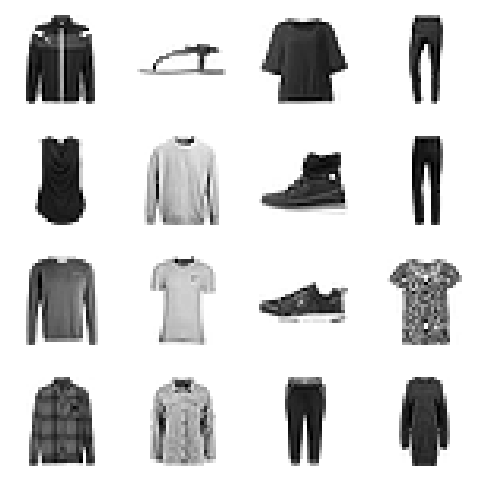

In [5]:
show_images(xb[:16], imsize=1.5)

## Parameters of the DDPM

In [7]:
# from "4. Experiments" in https://arxiv.org/pdf/2006.11239.pdf
beta_min, beta_max, n_steps = 0.0001, 0.02, 1000

# FORWARD PROCESS
"""We set the forward process variances to constants 
# increasing linearly from β1 = 10−4 to βT = 0.02."""
beta = torch.linspace(beta_min, beta_max, n_steps)

"""A notable property of the forward process is that it admits sampling xt at an
arbitrary timestep t in closed form: using the notation αt := 1 − βt and ¯αt := ∏t
s=1 αs"""
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

"""Experimentally, both σ2t = βt and σ2t = ˜βt = 1− ¯αt−1 1− ¯αt βt had similar results"""
sigma = beta.sqrt()

### Visualise our parameters

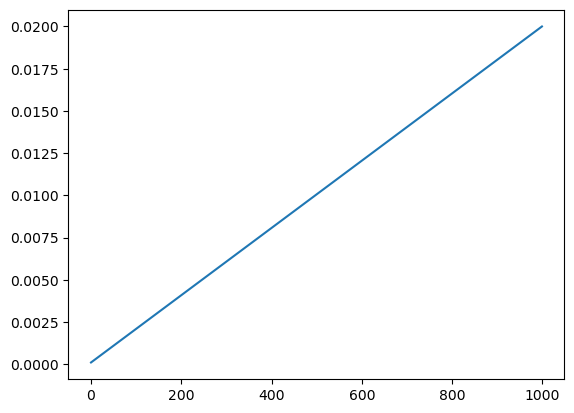

In [8]:
plt.plot(beta)

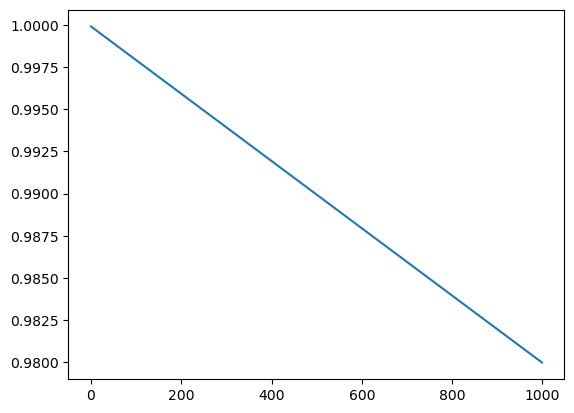

In [9]:
plt.plot(alpha)

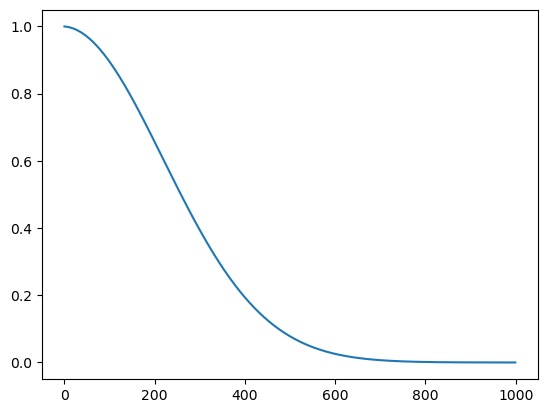

In [10]:
plt.plot(alpha_bar)

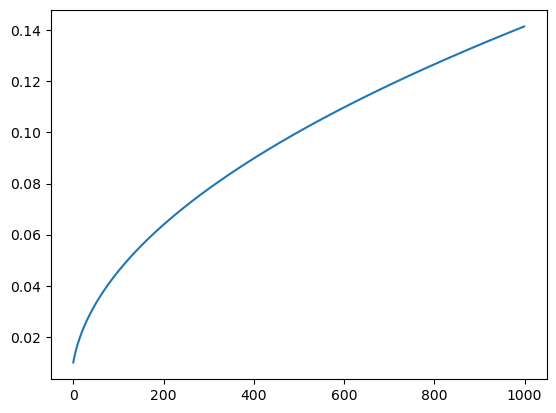

In [11]:
plt.plot(sigma)

### Noisify
We are writing the function for noisify, which first randomly generates a time step t, then adds noise to the image using the normal distribution and corresponding mean and variance at that time step.

In [25]:
#def noisify(x0, alpha_bar):
num_samples = xb[:16].shape[0]
t = torch.randint(0, n_steps, (num_samples,))


In [26]:
type(alpha_bar)

torch.Tensor

In [27]:
alpha_bar[t]

tensor([5.8015e-04, 9.2669e-01, 4.2087e-01, 5.1541e-03, 7.6613e-01, 2.6542e-01,
        9.3147e-01, 6.8315e-01, 8.9126e-05, 9.0798e-01, 1.4115e-04, 1.1671e-04,
        9.8151e-01, 3.0120e-03, 3.9961e-02, 3.1433e-01])

In [28]:
t

tensor([857,  82, 289, 720, 158, 359,  79, 190, 959,  93, 935, 945,  38, 756,
        562, 335])

Let's take index 82 to verify that our code is working correctly.

In [30]:
alpha_bar[82]

tensor(0.9267)

In [43]:
alpha_bar_t_sqrt = alpha_bar[t].sqrt().reshape(-1,1,1,1)
alpha_bar_t_complement = (1. - alpha_bar[t]).reshape(-1,1,1,1)

In [40]:
xb.shape

torch.Size([128, 1, 32, 32])

In [44]:
mean_dist_t = alpha_bar_t_sqrt * xb[:16]
var_dist_t = alpha_bar_t_complement * torch.eye(xb[:16].size(1) * xb[:16].size(2) * xb[:16].size(3), device=xb[:16].device)
mean_dist_t, var_dist_t

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [38]:
alpha_bar_t_sqrt.reshape(-1, 1, 1, 1).shape

torch.Size([16, 1, 1, 1])

In [37]:
xb[:16].shape

torch.Size([16, 1, 32, 32])

Let's put everything into a function.

In [48]:
def noisify(x0, alpha_bar):
    device = x0.device
    num_img = x0.shape[0]
    t = torch.randint(0, n_steps, (num_img,))
    noise = torch.randn_like(x0).to(device)
    xt = alpha_bar[t].sqrt().reshape(-1,1,1,1) * x0 + \
        (1. - alpha_bar[t]).sqrt().reshape(-1,1,1,1) * noise
    return (xt, t.to(device)), noise

In [50]:
res, noise = noisify(xb[:16], alpha_bar)

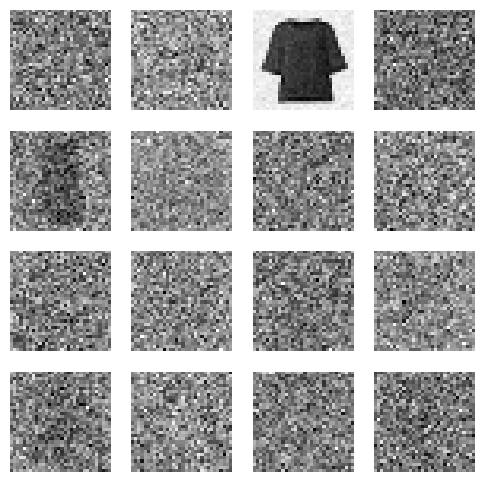

In [51]:
show_images(res[0], imsize=1.5)

Great! Our noisify function is working accordingly.